# Multi-GS Classifier
### Attempt to label events with gluon splitting and differentiate types of gluon splitting

### Labels: 0 = noGS, 1 = GSb , 2 = GSbb

## Setup the data

In [14]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

In [15]:
df = pd.read_csv('/Users/rohan/code/gs_classifier/output_multigs.csv')

feats = df.iloc[:,0:12]
y = df.isgs

In [16]:
feats.shape

(1541, 12)

In [17]:
feats.head(10)

,weight,dr_bb,bb_pt,bb_m,jet1_csv,jet1_pt,jet1_eta,jet1_phi,jet2_csv,jet2_pt,jet2_eta,jet2_phi
0,0.010080,3.168153,146.345215,1571.750244,0.991572,679.636658,0.259123,0.871540,0.962067,638.262634,-0.950709,-2.483592
1,0.010213,1.237230,568.637268,351.326141,0.952789,410.497620,1.856093,-3.062896,0.923160,164.860001,0.666116,-2.724229
2,0.009712,0.956219,231.636139,115.960991,0.996852,84.478951,-0.129236,1.402133,0.888687,150.055801,-1.027457,1.730089
3,0.009979,0.625336,884.483887,240.796066,0.963762,186.307327,1.013410,-2.106780,0.853772,702.267517,0.434318,-1.870778
4,0.010074,2.940529,277.393951,1224.259399,0.912212,710.185913,0.442450,-2.468202,0.896395,478.254578,-0.152350,0.411542
5,0.009696,2.432887,490.836060,373.417236,0.961387,518.018860,0.913551,2.025568,0.904230,56.406910,-0.276445,-0.096424
6,0.009766,2.399845,406.669495,385.500122,0.997387,69.960899,0.430898,-1.487286,0.953831,430.172821,-0.908712,2.804744
7,0.009818,0.777033,424.745941,153.147583,0.996344,102.089409,-2.306477,1.622080,0.990068,336.790070,-1.818888,1.017070
8,0.009587,1.345919,705.507812,225.399094,0.998911,44.010361,-0.281203,2.130650,0.918610,694.018066,-0.434562,-2.815382
9,0.009960,3.212383,172.939484,539.344788,0.998345,143.079178,1.466260,-0.359827,0.870681,305.462006,-0.004287,3.067330


In [18]:
y.shape

(1541,)

In [19]:
y.head(10)

0    1
1    0
2    2
3    0
4    1
5    0
6    0
7    0
8    1
9    1
Name: isgs, dtype: int64

#### Use K-folds for cross-validation

In [63]:
from sklearn.model_selection import KFold
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=452)

## Decision Tree
#### Loop over the folds, train, and evaluate the decision tree

In [167]:
def get_cm_gs(mat, norm=False):
    if mat.shape != (3,3): print("Matrix shape must be (3,3)")
        
    cm_gs = mat
    cm_gs[1,:]+=cm_gs[2,:]
    cm_gs[:,1]+=cm_gs[:,2]
    cm_gs = cm_gs[:2,:2]
    
    if norm:
        return(cm_gs/cm_gs.sum(axis=1)[:, np.newaxis])
    else:
        return(cm_gs)

In [176]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
tree = DecisionTreeClassifier(random_state=368)
cm_trains = np.zeros((3,3))
cm_tests = np.zeros((3,3))
for idx, (train, test) in enumerate(kf.split(feats, y)):
    # Setup weights and train/test sets
    train_weights = list(feats.iloc[train,0])
    X_train, y_train = feats.iloc[train,1:12], y.iloc[train]
    test_weights = list(feats.iloc[test,0])
    X_test, y_test = feats.iloc[test, 1:12], y.iloc[test]
    
    # Train tree
    tree.fit(X_train, y_train, sample_weight=train_weights)

    # Evaluate with confusion matrix
    # Print accuracy for each fold and the summed confusion matrix at the end
    print("Fold {}:").format(idx+1)

    cm_train = confusion_matrix(y_train, tree.predict(X_train), sample_weight=train_weights)
    print("\tTrain accuracy: {:.3f}").format(cm_train.trace()/cm_train.sum())
    cm_trains += cm_train
    
    cm_test = confusion_matrix(y_test, tree.predict(X_test), sample_weight=test_weights)
    print("\tTest accuracy: {:.3f}\n").format(cm_test.trace()/cm_test.sum())
    cm_tests += cm_test
    
print("Mean train accuracy: {:.3f}").format(cm_trains.trace()/cm_trains.sum())
print("Train CM:\n {}\n").format(cm_trains.round(3))
print("Norm. Train CM:\n {}\n").format(cm_trains/cm_trains.sum(axis=1))
print("Mean test accuracy: {:.3f}").format(cm_tests.trace()/cm_tests.sum())
print("Test CM:\n {}\n").format(cm_tests.round(3))
print("Norm. Test CM:\n {} \n").format(cm_tests/cm_tests.sum(axis=1)[:, np.newaxis])
print("Norm. Test CM GS:\n {}").format(get_cm_gs(cm_tests,True))

Fold 1:
	Train accuracy: 1.000
	Test accuracy: 0.461

Fold 2:
	Train accuracy: 1.000
	Test accuracy: 0.457

Fold 3:
	Train accuracy: 1.000
	Test accuracy: 0.467

Fold 4:
	Train accuracy: 1.000
	Test accuracy: 0.454

Fold 5:
	Train accuracy: 1.000
	Test accuracy: 0.471

Mean train accuracy: 1.000
Train CM:
 [[ 30.696   0.      0.   ]
 [  0.     21.555   0.   ]
 [  0.      0.     10.167]]

Norm. Train CM:
 [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]

Mean test accuracy: 0.462
Test CM:
 [[ 4.061  2.575  1.038]
 [ 2.374  2.247  0.768]
 [ 0.954  0.687  0.9  ]]

Norm. Test CM:
 [[ 0.52916402  0.33558063  0.13525535]
 [ 0.44045138  0.41700554  0.14254309]
 [ 0.3754028   0.27046923  0.35412797]] 

Norm. Test CM GS:
 [[ 0.52916402  0.47083598]
 [ 0.41960348  0.58039652]]


## Try Limiting Max Depth 

In [191]:
depth_trees = []
for depth in range(1,15):
    print("Depth {}:").format(depth)
    tree = DecisionTreeClassifier(random_state=368, max_depth=depth)
    cm_trains = np.zeros((3,3))
    cm_tests = np.zeros((3,3))
    for idx, (train, test) in enumerate(kf.split(feats, y)):
        # Setup weights and train/test sets
        train_weights = list(feats.iloc[train,0])
        X_train, y_train = feats.iloc[train,1:12], y.iloc[train]
        test_weights = list(feats.iloc[test,0])
        X_test, y_test = feats.iloc[test, 1:12], y.iloc[test]
    
        # Train tree
        tree.fit(X_train, y_train, sample_weight=train_weights)

        # Evaluate with confusion matrix
        # Print accuracy for each fold and the summed confusion matrix at the end
        cm_train = confusion_matrix(y_train, tree.predict(X_train), sample_weight=train_weights)
        cm_trains += cm_train
    
        cm_test = confusion_matrix(y_test, tree.predict(X_test), sample_weight=test_weights)
        cm_tests += cm_test
    
    print("Mean train accuracy: {:.3f}").format(cm_trains.trace()/cm_trains.sum())
    print("Mean test accuracy: {:.3f}").format(cm_tests.trace()/cm_tests.sum())

    mat_cm_gs = get_cm_gs(cm_tests)
    print("Mean test gs accuracy: {:.3f}\n").format(mat_cm_gs.trace()/mat_cm_gs.sum())
    
    print("Test CM:\n {}\n").format(cm_tests.round(3))
    print("Norm. Test CM:\n {} \n").format(cm_tests/cm_tests.sum(axis=1)[:, np.newaxis])
    print("Norm. Test CM GS:\n {}\n").format(get_cm_gs(cm_tests,True))
    print("{}\n").format(tree.feature_importances_)

Depth 1:
Mean train accuracy: 0.511
Mean test accuracy: 0.485
Mean test gs accuracy: 0.561

Test CM:
 [[ 5.285  2.389  0.   ]
 [ 4.455  3.475  0.   ]
 [ 1.35   1.191  0.   ]]

Norm. Test CM:
 [[ 0.68869675  0.31130325  0.        ]
 [ 0.56175892  0.43824108  0.        ]
 [ 0.53128345  0.46871655  0.        ]] 

Norm. Test CM GS:
 [[ 0.68869675  0.31130325]
 [ 0.55436223  0.44563777]]

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]

Depth 2:
Mean train accuracy: 0.534
Mean test accuracy: 0.525
Mean test gs accuracy: 0.633

Test CM:
 [[ 3.85   3.824  1.803]
 [ 1.906  6.024  3.362]
 [ 0.547  1.995  1.836]]

Norm. Test CM:
 [[ 0.40625684  0.4035235   0.19021966]
 [ 0.16881081  0.53349363  0.29769556]
 [ 0.12485444  0.4557478   0.41939776]] 

Norm. Test CM GS:
 [[ 0.40625684  0.59374316]
 [ 0.15653064  0.84346936]]

[ 0.          0.          0.48947408  0.51052592  0.          0.          0.
  0.          0.          0.          0.        ]

Depth 3:
Mean train accuracy: 0.580
Mean test accur

In [192]:
# The classifiers seem to prefer bb_m and jet1_csv as the most important variables

<function matplotlib.pyplot.show>

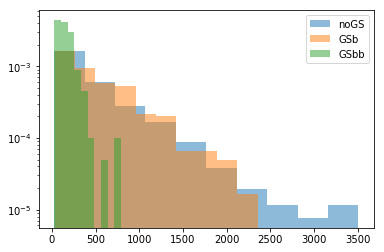

In [201]:
plt.hist(df[df.isgs==0].bb_m, alpha=0.5, label='noGS', log=True, normed=True)
plt.hist(df[df.isgs==1].bb_m, alpha=0.5, label='GSb', normed=True)
plt.hist(df[df.isgs==2].bb_m, alpha=0.5, label='GSbb', normed=True)
plt.legend(loc='upper right')
plt.show

<function matplotlib.pyplot.show>

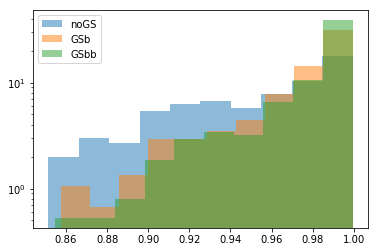

In [205]:
plt.hist(df[df.isgs==0].jet1_csv, alpha=0.5, label='noGS', log=True, normed=True)
plt.hist(df[df.isgs==1].jet1_csv, alpha=0.5, label='GSb', normed=True)
plt.hist(df[df.isgs==2].jet1_csv, alpha=0.5, label='GSbb', normed=True)
plt.legend(loc='upper left')
plt.show